## Initial imports

In [21]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

from scm.conformers import ConformersJob
from scm.plams import *

init();  # this line is not required in AMS2025+

## Initial structure

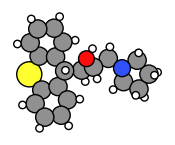

In [2]:
molecule = from_smiles("OC(CC1c2ccccc2Sc2ccccc21)CN1CCCC1")
plot_molecule(molecule);

## Generate conformers with RDKit and UFF
The fastest way to generate conformers is to use RDKit with the UFF force field.

Below we specify to generate 16 initial conformers. The final number of conformers may be smaller, as the geometry optimization may cause several structures to enter the same minimum.

### Conformer generation settings

In [3]:
s = Settings()
s.input.ams.Task = "Generate"  # default
s.input.ams.Generator.Method = "RDKit"  # default
s.input.ams.Generator.RDKit.InitialNConformers = 16  # optional, non-default
s.input.ForceField.Type = "UFF"  # default

### Conformer generation input file

In [4]:
print(ConformersJob(settings=s).get_input())

Generator
  Method RDKit
  RDKit
    InitialNConformers 16
  End
End

Task Generate


Engine ForceField
  Type UFF
EndEngine




### Run conformer generation

In [5]:
generate_job = ConformersJob(name="generate", molecule=molecule, settings=s)
generate_job.run();

[04.02|15:07:47] JOB generate STARTED
[04.02|15:07:47] JOB generate RUNNING
[04.02|15:08:56] JOB generate FINISHED
[04.02|15:08:56] JOB generate SUCCESSFUL


## Conformer generation results

### Some helper functions

In [6]:
def get_energies(job: ConformersJob, temperature=298, unit="kcal/mol"):
    return job.results.get_relative_energies(unit)


def get_populations(job: ConformersJob, temperature=298, unit="kcal/mol"):
    return job.results.get_boltzmann_distribution(temperature)


def get_energy_header(unit="kcal/mol"):
    return f"ΔE [{unit}]"


def get_population_header(temperature=298):
    return f"Pop. (T = {temperature} K)"


def get_conformers(job: ConformersJob):
    return job.results.get_conformers()


def plot_conformers(job: ConformersJob, indices=None, temperature=298, unit="kcal/mol", lowest=True):
    molecules = get_conformers(job)
    energies = get_energies(job, unit)
    populations = get_populations(job, temperature)

    if isinstance(indices, int):
        N_plot = min(indices, len(energies))
        if lowest:
            indices = list(range(N_plot))
        else:
            indices = np.linspace(0, len(energies) - 1, N_plot, dtype=np.int32)
    if indices is None:
        indices = list(range(min(3, len(energies))))

    fig, axes = plt.subplots(1, len(indices), figsize=(12, 3))
    if len(indices) == 1:
        axes = [axes]

    for ax, i in zip(axes, indices):
        mol = molecules[i]
        E = energies[i]
        population = populations[i]

        plot_molecule(mol, ax=ax)
        ax.set_title(f"#{i+1}\nΔE = {E:.2f} kcal/mol\nPop.: {population:.3f} (T = {temperature} K)")

In [22]:
try:
    # For AMS2025+ can use JobAnalysis class to perform results analysis
    from scm.plams import JobAnalysis

    def print_results(job: ConformersJob, temperature=298, unit="kcal/mol"):
        ja = (
            JobAnalysis(std_fields=None)
            .add_job(job)
            .add_field(
                "Id",
                lambda j: list(range(1, len(get_conformers(j)) + 1)),
                display_name="Conformer Id",
                expansion_depth=1,
            )
            .add_field("Energies", get_energies, display_name=get_energy_header(), expansion_depth=1, fmt=".2f")
            .add_field(
                "Populations", get_populations, display_name=get_population_header(), expansion_depth=1, fmt=".3f"
            )
        )

        # Pretty-print if running in a notebook
        if "ipykernel" in sys.modules:
            ja.display_table()
        else:
            print(ja.to_table())

except ImportError:

    def print_results(job: ConformersJob, temperature=298, unit="kcal/mol"):
        energies = get_energies(job, temperature, unit)
        populations = get_populations(job, temperature, unit)

        print(f"Total # conformers in set: {len(energies)}")
        dE_header = get_energy_header(unit)
        pop_header = get_population_header(temperature)
        print(f'{"#":>4s} {dE_header:>14s} {pop_header:>18s}')

        for i, (E, pop) in enumerate(zip(energies, populations)):
            print(f"{i+1:4d} {E:14.2f} {pop:18.3f}")

### Actual results

Below we see that the **conformer generation gave 14 distinct conformers**, where the highest-energy conformer is 18 kcal/mol higher in energy than the lowest energy conformer.

You can also see the **relative populations** of these conformers at the specified temperature. The populations are calculated from the **Boltzmann distribution** and the relative energies.

In [23]:
unit = "kcal/mol"
temperature = 298

In [24]:
print_results(generate_job, temperature, unit)

| Conformer Id | ΔE [kcal/mol] | Pop. (T = 298 K) |
|--------------|---------------|------------------|
| 1            | 0.00          | 0.557            |
| 2            | 0.57          | 0.214            |
| 3            | 1.00          | 0.102            |
| 4            | 1.18          | 0.076            |
| 5            | 2.12          | 0.015            |
| 6            | 2.22          | 0.013            |
| 7            | 2.40          | 0.010            |
| 8            | 2.50          | 0.008            |
| 9            | 3.44          | 0.002            |
| 10           | 3.53          | 0.001            |
| 11           | 3.76          | 0.001            |
| 12           | 5.50          | 0.000            |
| 13           | 6.78          | 0.000            |
| 14           | 12.85         | 0.000            |
| 15           | 15.70         | 0.000            |
| 16           | 18.79         | 0.000            |

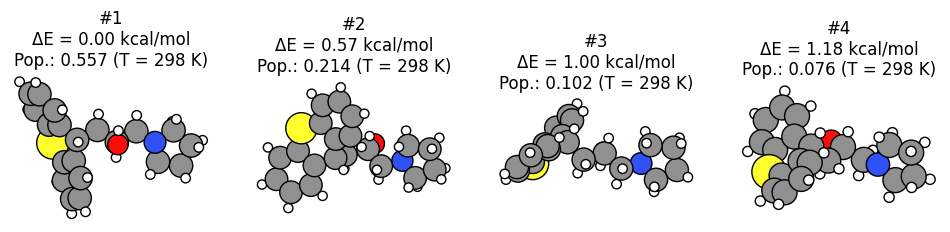

In [25]:
plot_conformers(generate_job, 4, temperature=temperature, unit=unit, lowest=True)

## Re-optimize conformers with GFNFF

The UFF force field is not very accurate for geometries and energies. From an initial conformer set you can reoptimize it with a better level of theory.

The **Optimize** task performs **GeometryOptimization** jobs on each conformer in a set.

Below, the most stable conformers (within 8 kcal/mol of the most stable conformer) at the UFF level of theory are re-optimized with GFNFF, which gives more accurate geometries.

In [11]:
s = Settings()
s.input.ams.Task = "Optimize"
s.input.ams.InputConformersSet = os.path.abspath(generate_job.results.rkfpath())  # must be absolute path
s.input.ams.InputMaxEnergy = 8.0  # only conformers within 8 kcal/mol at the PREVIOUS level of theory
s.input.GFNFF  # or choose a different engine if you don't have a GFNFF license

reoptimize_job = ConformersJob(settings=s, name="reoptimize")
print(reoptimize_job.get_input())

InputConformersSet /path/plams/examples/ConformersGeneration/plams_workdir.006/generate/conformers.rkf

InputMaxEnergy 8.0

Task Optimize


Engine GFNFF
EndEngine




In [12]:
reoptimize_job.run();

[04.02|15:08:56] JOB reoptimize STARTED
[04.02|15:08:56] JOB reoptimize RUNNING
[04.02|15:09:01] JOB reoptimize FINISHED
[04.02|15:09:01] JOB reoptimize SUCCESSFUL


In [26]:
print_results(reoptimize_job, temperature=temperature, unit=unit)

| Conformer Id | ΔE [kcal/mol] | Pop. (T = 298 K) |
|--------------|---------------|------------------|
| 1            | 0.00          | 0.270            |
| 2            | 0.11          | 0.225            |
| 3            | 0.41          | 0.134            |
| 4            | 0.63          | 0.093            |
| 5            | 0.91          | 0.058            |
| 6            | 0.97          | 0.052            |
| 7            | 1.02          | 0.048            |
| 8            | 1.14          | 0.039            |
| 9            | 1.19          | 0.036            |
| 10           | 1.41          | 0.025            |
| 11           | 1.57          | 0.019            |

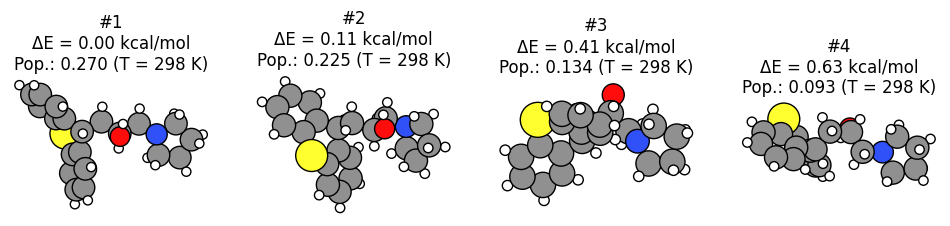

In [14]:
plot_conformers(reoptimize_job, 4, temperature=temperature, unit=unit, lowest=True)

## Score conformers with DFTB

If you have many conformers or a very large molecule, it can be computationally expensive to do the conformer generation or reoptimization and a high level of theory.

The **Score** task runs **SinglePoint** jobs on the conformers in a set. This lets you use a more computationally expensive method. Here, we choose DFTB, although normally you may choose some DFT method.

In [15]:
s = Settings()
s.input.ams.Task = "Score"
s.input.ams.InputConformersSet = os.path.abspath(reoptimize_job.results.rkfpath())  # must be absolute path
s.input.ams.InputMaxEnergy = 4.0  # only conformers within 4 kcal/mol at the PREVIOUS level of theory
s.input.DFTB.Model = "GFN1-xTB"  # or choose a different engine if you don't have a DFTB license
# s.input.adf.XC.GGA = 'PBE'                       # to use ADF PBE
# s.input.adf.XC.DISPERSION = 'GRIMME3 BJDAMP'     # to use ADF PBE with Grimme D3(BJ) dispersion

score_job = ConformersJob(settings=s, name="score")
score_job.run();

[04.02|15:09:02] JOB score STARTED
[04.02|15:09:02] JOB score RUNNING
[04.02|15:09:05] JOB score FINISHED
[04.02|15:09:05] JOB score SUCCESSFUL


In [30]:
print_results(score_job, temperature=temperature, unit=unit)

| Conformer Id | ΔE [kcal/mol] | Pop. (T = 298 K) |
|--------------|---------------|------------------|
| 1            | 0.00          | 0.373            |
| 2            | 0.34          | 0.209            |
| 3            | 0.40          | 0.188            |
| 4            | 0.70          | 0.114            |
| 5            | 1.06          | 0.063            |
| 6            | 1.85          | 0.016            |
| 7            | 1.89          | 0.015            |
| 8            | 2.41          | 0.006            |
| 9            | 2.48          | 0.006            |
| 10           | 2.59          | 0.005            |
| 11           | 2.73          | 0.004            |

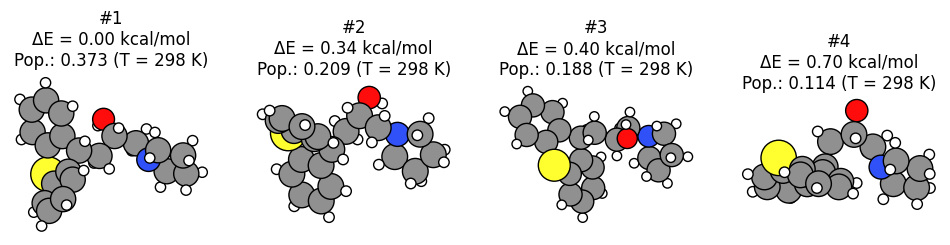

In [31]:
plot_conformers(score_job, 4, temperature=temperature, unit=unit, lowest=True)

Here, you see that from the conformers in the set, **DFTB predicts a different lowest-energy conformer than GFNFF** (compare to previous figure).

## Filter a conformer set

In practice, you may have generated thousands of conformers for a particular structure. Many of those conformers may be so high in energy that their Boltzmann weights are very small.

The **Filter** task only filters the conformers, it does not perform any additional calculations. It can be used to reduce a conformer set so that it is more convenient to work with.

Below, we filter the conformers set to only the conformers within 1 kcal/mol of the minimum.

In [17]:
s = Settings()
s.input.ams.Task = "Filter"
s.input.ams.InputConformersSet = os.path.abspath(score_job.results.rkfpath())
s.input.ams.InputMaxEnergy = 1.0

filter_job = ConformersJob(settings=s, name="filter")
filter_job.run();

[04.02|15:09:05] JOB filter STARTED
[04.02|15:09:05] JOB filter RUNNING
[04.02|15:09:06] JOB filter FINISHED
[04.02|15:09:06] JOB filter SUCCESSFUL


In [32]:
print_results(filter_job, temperature=temperature, unit=unit)

| Conformer Id | ΔE [kcal/mol] | Pop. (T = 298 K) |
|--------------|---------------|------------------|
| 1            | 0.00          | 0.421            |
| 2            | 0.34          | 0.236            |
| 3            | 0.40          | 0.213            |
| 4            | 0.70          | 0.129            |

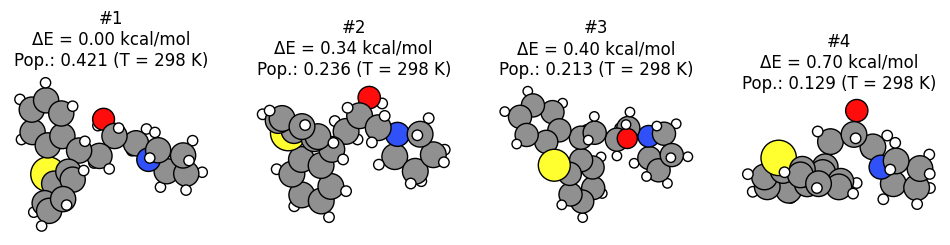

In [19]:
plot_conformers(filter_job, 4, temperature=temperature, unit=unit, lowest=True)

The structures and energies are identical to before. However, the relative populations changed slightly as there are now fewer conformers in the set.

## More about conformers

* Try **CREST** instead of RDKit to generate the initial conformer set

* The **Expand** task can be used to expand a set of conformers.